In [ ]:
# MIT License
#
#@title Copyright (c) 2021 CCAI Community Authors { display-mode: "form" }
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

#https://github.com/Open-Catalyst-Project

このノートブックではOCPの汎用性を推し量るために、MDを実施してみます。具体的な案件として、Ni-Cu合金系における相互拡散係数を、合金組成に対して計算しその妥当性を検証します。この序文を作成している現在時点において、検証の結果がどうなるか私自身も知りません。さて、どうなるでしょうか？？

0．OCP力場の導入

1．必要な関数の定義

1－1　バルク合金の構造最適化

1－2　MD計算の実施

1－3　拡散係数の計算

2．拡散係数の組成依存性について、文献値との比較

## 0. 学習済みモデル（力場）のダウンロード

学習済みのモデルを右記リンクからダウンロードします。[here](https://github.com/Open-Catalyst-Project/ocp/blob/master/MODELS.md)学習済みのモデルはASEのCalculatorクラスとして使用できます。
※今回はリンク先から該当ファイルを直接ダウンロードし、計算環境のフォルダに格納しました。

In [ ]:
from ocpmodels.common.relaxation.ase_utils import OCPCalculator
import ase.io
from ase.optimize import BFGS, LBFGS, FIRE
from ase.build import add_adsorbate, molecule, bulk
import os
from ase.constraints import FixAtoms
import numpy as np
import pandas as pd
import random
from ase.build import molecule, bulk
from ase.build import bcc100, bcc110, bcc111, fcc111, fcc100, fcc110, fcc211, hcp0001, hcp10m10, diamond100, diamond111
from ase.visualize import view
from ase.data import atomic_numbers
import collections
from ase.io.trajectory import Trajectory
from ase.io import extxyz
from pymatgen.io.cif import CifWriter
import ase
from ase import Atoms, units
from ase.units import Bohr,Rydberg,kJ,kB,fs,Hartree,mol,kcal
from ase.io import read, write
from ase.build import surface, molecule, add_adsorbate
from ase.constraints import FixAtoms, FixedPlane, FixBondLength, ExpCellFilter
from ase.neb import NEB
from ase.vibrations import Vibrations
from ase.thermochemistry import IdealGasThermo
from ase.visualize import view
from ase.build.rotate import minimize_rotation_and_translation
from ase.optimize import BFGS, LBFGS, FIRE
from ase.md import MDLogger
from ase.io import read, write, Trajectory
from ase.build import sort
from ase.visualize import view
from ase.visualize.plot import plot_atoms
import matplotlib.pyplot as plt
from pymatgen.ext.matproj import MPRester
import plotly.express as px

#モデルの置き場所
checkpoint_path = "C:/Users/****/ocp/gemnet_t_direct_h512_all.pt"
config_yml_path = r"C:/Users/****/ocp/configs/s2ef/all/gemnet/gemnet-dT.yml"

#Define the calculator
calc = OCPCalculator(config_yml=config_yml_path, checkpoint=checkpoint_path, cpu = False)

In [ ]:
#MD計算に必要なライブラリ
import os
calculator = calc

from ase.build import bulk
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution,Stationary
from ase.md.verlet import VelocityVerlet
from ase.md import MDLogger
from ase import units
from time import perf_counter
import numpy as np
import warnings
warnings.simplefilter('ignore')

## 1-1. バルク結晶の作成と構造最適化

バルク結晶を作成し、構造最適化を行います。今回はNi-Cu合金系を対象としてみましょう。

Ni-Cu合金における相互拡散係数は、最も初期にその詳細が定量化された系の一つです。ここでは、北海道大学の実験テキストからその実験値を引用します。図からわかるとおり、Ni-Cu相互拡散係数（合金中におけるNi、Cuそれぞれの拡散係数）は合金の組成に依存します。というのも、相互拡散係数は合金を攻勢する各元素の拡散係数に依存しており、たいていの場合元素が変われば拡散係数は大きく異なるためです。

グラフより、相互拡散係数はNiの方がCuよりも大きく、またNiの濃度が増えるとその値はだんだんと小さくなり、最後は逆転する様子が見て取れます。OCP力場を用いたMDにより、この傾向が再現できるかというのが今回のポイントです（当然ですが、定性的にでも傾向が再現できるのであれば、それだけでも材料開発上どれだけ有用かは計り知れないものがあるでしょう）。

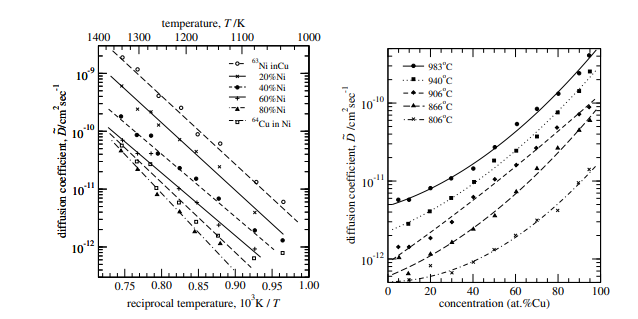
https://www.eng.hokudai.ac.jp/labo/lmsm/jikken/text/diffusion/text.pdf

In [ ]:
def get_column_with_min_value_in_row_zero(df):
    # 0行目の値が最小となる列のインデックスを取得
    min_col_index = df.iloc[0].idxmin()

    # 対象の列を抽出
    min_col = df[min_col_index]

    return min_col

In [ ]:
def modify_compositions(insert_num, base_num, insert_ratio, base_ratio, slab):
    #結晶構造の元素番号を確認する
    numbers = slab.get_atomic_numbers()
    #base_atomの個数
    base_count = np.count_nonzero(numbers == base_num)
    #base_atomのindex
    indices_base_count = np.where(numbers == base_num)[0]
    #base_atomのindexを、任意比率でinsert_atomに変更
    np.random.seed(1)
    replace_index = np.random.choice(indices_base_count, size= round(base_count*insert_ratio / (insert_ratio + base_ratio)), replace=False)
    print(f"Replace {replace_index} atom")
    numbers[replace_index] = insert_num
    slab.set_atomic_numbers(numbers)
    return slab

In [ ]:
def bulk_set_opt(insert_num, base_num, insert_ratio, base_ratio, atoms):
    fcc_energies = []
    for i in np.linspace(0.9, 1.1):
        size = (5, 5, 5)
        bulk_test = bulk(atoms)*size
        bulk_test = modify_compositions(insert_num, base_num, insert_ratio, base_ratio, bulk_test)
        ref = bulk_test.cell
        bulk_test.cell = i * ref
        print(bulk_test.cell)
        bulk_test.set_tags(np.ones(len(bulk_test)))

        bulk_test.calc = calc

        e = (bulk_test.get_potential_energy())
        fcc_energies.append(e)
        del bulk_test, ref
        
    bulk_energy = pd.DataFrame([fcc_energies, np.linspace(0.9, 1.1)])
    opt_i = get_column_with_min_value_in_row_zero(bulk_energy)[1]

    bulk_test = bulk(atoms)*size
    bulk_test = modify_compositions(insert_num, base_num, insert_ratio, base_ratio, bulk_test)
    ref = bulk_test.cell
    bulk_test.cell = opt_i * ref
    print(bulk_test.cell)
    return bulk_test


In [ ]:
#構造最適化が出来ているか、10% Ni-Cu合金にてテストします
atoms = bulk_set_opt(28,29,0.1,0.9, "Cu")
atoms


## 1-2. MD計算

MD計算（分子動力学計算）とは、一定の仮定のもとに着目する系の時間発展を見ることを指します。今回は初期の熱エネルギーを指定して結晶系の運動を見ていきましょう。この計算には初期のエネルギーと、任意の結晶に対し力とエネルギーを計算する力場があればよいので、OCP力場は理論上この計算に適用が出来ます。ただし、OCP力場は典型的な結晶構造、これをもとに構成されたスラブ構造およびそれに吸着した分子に対する力とエネルギー、なかでも吸着エネルギーに着目した力場ですので、このような使い方に果たしてどこまでついてこられるかという不安があります。

※ちなみに、初期の熱エネルギーを指定する他の手法としては、温度と圧力を一定に保つ方法も存在します。ただこの手法、系のstressが分からないと実装出来ないのですがOCP calculatorには今のところこの実装がありません。原理的には出来るはずですので、実装を待ちたいところです。

In [ ]:
# Print statements
def print_dyn():
    imd = dyn.get_number_of_steps()
    time_md = time_step*imd
    etot  = atoms.get_total_energy()
    ekin  = atoms.get_kinetic_energy()
    epot  = atoms.get_potential_energy()
    temp_K = atoms.get_temperature()
    print(f"   {imd: >3}     {etot:.9f}     {ekin:.9f}    {epot:.9f}   {temp_K:.2f}")


In [ ]:
def MD_calculation(atoms, time_step, temperature, num_md_steps, num_interval):

    print("atoms = ",atoms)
    atoms_name = str(atoms.symbols)

    # Set calculator
    atoms.calc = calculator

    # Set the momenta corresponding to the given "temperature"
    MaxwellBoltzmannDistribution(atoms, temperature_K=temperature,force_temp=True)
    Stationary(atoms)  # Set zero total momentum to avoid drifting

    # Set output filenames
    output_filename = "./output/metal_" + atoms_name
    log_filename = output_filename + ".log"
    print("log_filename = ",log_filename)
    traj_filename = output_filename + ".traj"
    print("traj_filename = ",traj_filename)

    # Define the MD dynamics class object
    dyn = VelocityVerlet(atoms,
                         time_step * units.fs,
                         trajectory = traj_filename,
                         loginterval=num_interval
                        )
    
    # Print statements
    def print_dyn():
        imd = dyn.get_number_of_steps()
        time_md = time_step*imd
        etot  = atoms.get_total_energy()
        ekin  = atoms.get_kinetic_energy()
        epot  = atoms.get_potential_energy()
        temp_K = atoms.get_temperature()
        print(f"   {imd: >3}     {etot:.9f}     {ekin:.9f}    {epot:.9f}   {temp_K:.2f}")

    dyn.attach(print_dyn, interval=num_interval)

    # Set MD logger
    dyn.attach(MDLogger(dyn, atoms, log_filename, header=True, stress=False,peratom=False, mode="w"), interval=num_interval)

    # Now run MD simulation
    print(f"\n    imd     Etot(eV)    Ekin(eV)    Epot(eV)    T(K)")
    dyn.run(num_md_steps)

    print("\nNormal termination of the MD run!")


In [ ]:
#正常に走るかどうかテスト
MD_calculation(atoms, 1, 1000, 1000, 100)

## 1-3. 拡散係数の計算

MD計算のトラジェクトファイルから相互拡散係数を計算します。といってもそんなに難しい話ではなく、格子中にふくまれる各原子の単位時間における移動距離を求めたのち、原子数で割ったものが拡散係数となります。そこで、結晶格子から構成元素を読込、それぞれについて相互拡散係数を算出してみましょう。

In [ ]:
def calculate_diffusion_coefficient(atoms):
    atoms_name = str(atoms.symbols)

    # Set output filenames
    output_filename = "./output/metal_" + atoms_name
    log_filename = output_filename + ".log"
    print("log_filename = ",log_filename)
    traj_filename = output_filename + ".traj"
    print("traj_filename = ",traj_filename)
    
    df = pd.read_csv(log_filename, delim_whitespace=True)
    traj = Trajectory(traj_filename)

    Ni_diffusivity = np.linalg.norm(traj[-1][traj[-1].get_atomic_numbers() == 28].positions - traj[0][traj[0].get_atomic_numbers() == 28].positions) / df["Time[ps]"][len(df)-1] / len(traj[0][traj[0].get_atomic_numbers() == 28].positions)
    Cu_diffusivity = np.linalg.norm(traj[-1][traj[-1].get_atomic_numbers() == 29].positions - traj[0][traj[0].get_atomic_numbers() == 29].positions) / df["Time[ps]"][len(df)-1] / len(traj[0][traj[0].get_atomic_numbers() == 29].positions)
    
    Temperature = df["T[K]"].loc[1:].mean()
    
    return Ni_diffusivity, Cu_diffusivity, Temperature



## 2. 組成ごとに計算、文献と比較

Niの組成比を振って拡散係数を求めてみます。結果は下図のようになり、Ni-Cu合金中における相互拡散係数の濃度依存性が（傾向として）再現されました。なお一部の計算結果では温度が極端に上昇しており、力場が破綻したことが示唆されました。なので、そうした結果については計算から除外しております。
（2023.2.18追記）力場が破綻した、というのは誤解を招く表現でして、これには（おそらく）物理化学的な要因があります。NVEで初期温度を1000 Kに設定すると落ち着いたときの温度は500～600 Kとなります。ただ、今回参照した北大の相互拡散係数に関する実験テキストにもある通りNi-Cuは元来300度未満だと固溶しない領域が出てきてしまいます。なのでこの実験は少なくとも300℃以上でやりなさい、という但し書きがついていたのを私がすっかり見過ごしていたのでした。ケーススタディでも示す通り、OCP力場は構造が熱力学的に安定か否か、という情報を（少なくとも典型的な構造については）ある程度学習しているようです。

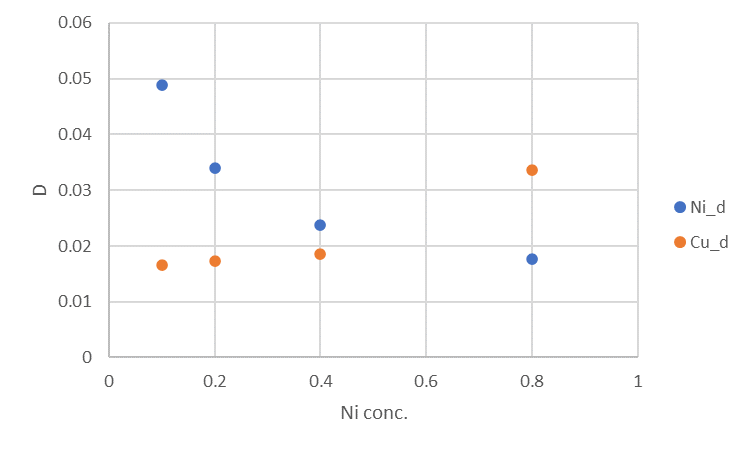

In [ ]:
diffusivity_data = pd.DataFrame(np.empty((5, 4)), columns = ["Ni_conc","Ni_d","Cu_d", "T"])

for x in [0.1, 0.2, 0.4, 0.6, 0.8]:
    atoms = bulk_set_opt(28,29,x,1-x, "Cu")
    MD_calculation(atoms, 1, 1000, 1000, 100)
    Ni_diffusivity, Cu_diffusivity, Temperature = calculate_diffusion_coefficient(atoms)
    
    diffusivity_data = diffusivity_data.append({'Ni_conc': x,
                                                'Ni_d': Ni_diffusivity,
                                                'Cu_d': Cu_diffusivity,
                                                "T": Temperature}, ignore_index = True)

    print(diffusivity_data)

diffusivity_data.to_csv("20230122_diffusivity_data.csv")
    
    